# Weather data exploration (hourly)
This notebook explores the Dark Sky hourly weather dataset and prepares it
for later merging with the half-hourly energy series.

Goals:
- parse timestamps and confirm time coverage
- check missing values and basic distributions
- inspect key continuous variables over time


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

weather_path = '/Users/eugeneleach/code/bertieford/forecast-and-flex/notebooks/weather_hourly_darksky.csv'
weather = pd.read_csv(weather_path)
weather.head()


,visibility,windBearing,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,5.97,104,10.24,2011-11-11 00:00:00,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
1,4.88,99,9.76,2011-11-11 01:00:00,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2,3.70,98,9.46,2011-11-11 02:00:00,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
3,3.12,99,9.23,2011-11-11 03:00:00,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
4,1.85,111,9.26,2011-11-11 04:00:00,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


## 1) Parse timestamps and sort
We convert the `time` column to a datetime index so we can resample and align
with energy data later.


In [2]:
weather['time'] = pd.to_datetime(weather['time'])
weather = weather.sort_values('time')
weather = weather.set_index('time')

weather.index.min(), weather.index.max(), weather.index.inferred_freq


(Timestamp('2011-11-01 00:00:00'), Timestamp('2014-03-31 22:00:00'), None)

## 2) Missing values
We check for gaps and decide how to handle them before modeling.


In [3]:
missing = weather.isna().mean().sort_values(ascending=False)
missing


pressure               0.000614
visibility             0.000000
windBearing            0.000000
temperature            0.000000
dewPoint               0.000000
apparentTemperature    0.000000
windSpeed              0.000000
precipType             0.000000
icon                   0.000000
humidity               0.000000
summary                0.000000
dtype: float64

## 3) Summary statistics (numeric columns)
A quick overview of ranges and variability for continuous features.


In [4]:
weather.describe().T


,count,mean,std,min,25%,50%,75%,max
visibility,21165.0,11.166485,3.099337,0.18,10.12,12.26,13.08,16.09
windBearing,21165.0,195.685897,90.629453,0.00,121.00,217.00,256.00,359.00
temperature,21165.0,10.471486,5.781904,-5.64,6.47,9.93,14.31,32.40
dewPoint,21165.0,6.530501,5.041965,-9.98,2.82,6.57,10.33,19.88
pressure,21152.0,1014.125153,11.388337,975.74,1007.43,1014.78,1022.05,1043.32
apparentTemperature,21165.0,9.230338,6.940919,-8.88,3.90,9.36,14.32,32.42
windSpeed,21165.0,3.905215,2.026854,0.04,2.42,3.68,5.07,14.80
humidity,21165.0,0.781829,0.140369,0.23,0.70,0.81,0.89,1.00


## 4) Categorical distributions
Inspect the weather categories that may be useful as model inputs later.


In [5]:
cat_cols = ['precipType', 'icon', 'summary']
{c: weather[c].value_counts().head(10) for c in cat_cols}


{'precipType': precipType
 rain    20370
 snow      795
 Name: count, dtype: int64,
 'icon': icon
 partly-cloudy-day      7658
 partly-cloudy-night    5075
 clear-night            4661
 clear-day              1110
 wind                    989
 cloudy                  979
 fog                     693
 Name: count, dtype: int64,
 'summary': summary
 Partly Cloudy               6638
 Mostly Cloudy               6095
 Clear                       5771
 Overcast                     979
 Foggy                        693
 Breezy and Mostly Cloudy     385
 Breezy and Partly Cloudy     267
 Breezy                       195
 Breezy and Overcast           83
 Windy and Mostly Cloudy       29
 Name: count, dtype: int64}

## 5) Time-series plots
Plot key variables to spot seasonality and long-term shifts.


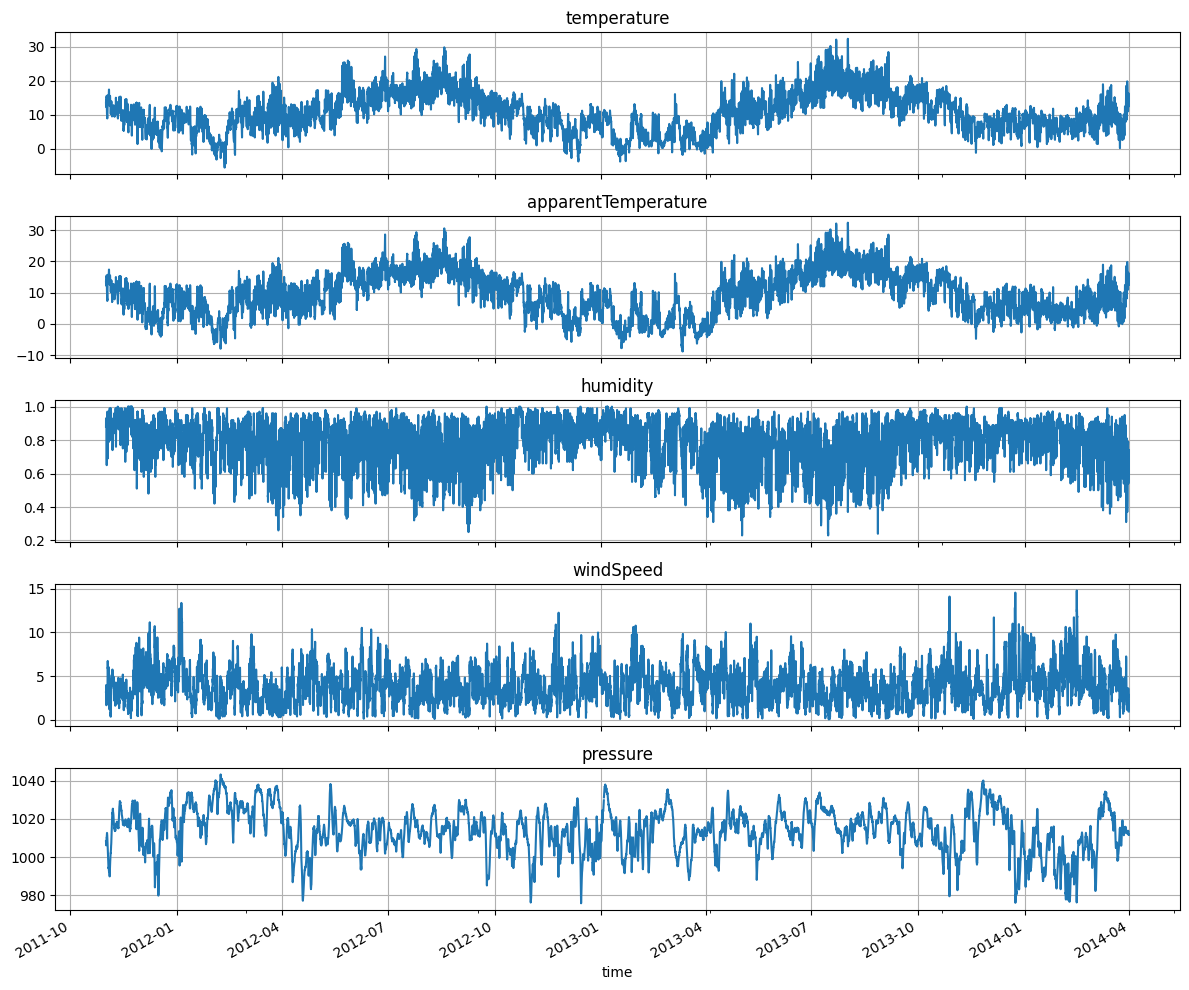

In [6]:
cols = ['temperature', 'apparentTemperature', 'humidity', 'windSpeed', 'pressure']
fig, axes = plt.subplots(len(cols), 1, figsize=(12, 10), sharex=True)
for ax, col in zip(axes, cols):
    weather[col].plot(ax=ax)
    ax.set_title(col)
    ax.grid(True)
fig.tight_layout()
plt.show()


## 6) Optional: hourly coverage check
Verify we have a continuous hourly series (no missing timestamps).


In [7]:
expected_index = pd.date_range(
    start=weather.index.min(),
    end=weather.index.max(),
    freq='H'
)
missing_timestamps = expected_index.difference(weather.index)
len(missing_timestamps)


/var/folders/ck/jd_mqjtj1497d9kbkkk3g33h0000gn/T/ipykernel_63421/3035160512.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  expected_index = pd.date_range(


2

## 7) Load half-hourly energy data (2013 only)
We load the half-hourly series, clean the energy column, and filter to 2013
to match the weather modeling scope.


In [8]:
energy_path = '/Users/eugeneleach/code/bertieford/forecast-and-flex/notebooks/block_0.csv'
energy = pd.read_csv(energy_path, parse_dates=['tstp'])

energy = energy[energy['LCLid'] == 'MAC000002'].copy()
energy['energy(kWh/hh)'] = (
    energy['energy(kWh/hh)'].replace('Null', 0)
)
energy['energy(kWh/hh)'] = (
    pd.to_numeric(energy['energy(kWh/hh)'], errors='coerce')
    .fillna(0)
)

energy = energy.sort_values('tstp').set_index('tstp')
energy_2013 = energy.loc['2013-01-01':'2013-12-31 23:30:00']
energy_2013 = energy_2013.asfreq('30T')
energy_2013.head()


/var/folders/ck/jd_mqjtj1497d9kbkkk3g33h0000gn/T/ipykernel_63421/3439434726.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  energy_2013 = energy_2013.asfreq('30T')


,LCLid,energy(kWh/hh)
tstp,,
2013-01-01 00:00:00,MAC000002,0.219
2013-01-01 00:30:00,MAC000002,0.241
2013-01-01 01:00:00,MAC000002,0.191
2013-01-01 01:30:00,MAC000002,0.235
2013-01-01 02:00:00,MAC000002,0.182


## 8) Filter and align weather to half-hourly
Weather is hourly; we upsample to 30-minute intervals and interpolate so we
can align it with the energy series for SARIMAX.


In [9]:
weather_2013 = weather.loc['2013-01-01':'2013-12-31 23:00:00'].copy()
weather_2013 = weather_2013.asfreq('H')
weather_2013 = weather_2013.interpolate('time').ffill().bfill()

weather_30m = weather_2013.asfreq('30T')
weather_30m = weather_30m.interpolate('time').ffill().bfill()
weather_30m.head()


/var/folders/ck/jd_mqjtj1497d9kbkkk3g33h0000gn/T/ipykernel_63421/3604248640.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_2013 = weather_2013.asfreq('H')
/var/folders/ck/jd_mqjtj1497d9kbkkk3g33h0000gn/T/ipykernel_63421/3604248640.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  weather_2013 = weather_2013.interpolate('time').ffill().bfill()
/var/folders/ck/jd_mqjtj1497d9kbkkk3g33h0000gn/T/ipykernel_63421/3604248640.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  weather_30m = weather_2013.asfreq('30T')
/var/folders/ck/jd_mqjtj1497d9kbkkk3g33h0000gn/T/ipykernel_63421/3604248640.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interp

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
time,,,,,,,,,,,
2013-01-01 00:00:00,13.280,269.0,7.010,2.600,1008.19,3.66,5.460,rain,partly-cloudy-night,0.730,Partly Cloudy
2013-01-01 00:30:00,13.175,271.0,7.250,2.665,1008.47,3.95,5.485,rain,partly-cloudy-night,0.725,Partly Cloudy
2013-01-01 01:00:00,13.070,273.0,7.490,2.730,1008.75,4.24,5.510,rain,partly-cloudy-night,0.720,Partly Cloudy
2013-01-01 01:30:00,13.295,273.5,7.325,2.230,1009.11,3.99,5.625,rain,partly-cloudy-night,0.700,Partly Cloudy
2013-01-01 02:00:00,13.520,274.0,7.160,1.730,1009.47,3.74,5.740,rain,partly-cloudy-night,0.680,Partly Cloudy


## 9) Merge energy and weather
We keep only timestamps where both datasets are present, and select
continuous weather features as exogenous inputs.


In [10]:
data = energy_2013[['energy(kWh/hh)']].join(weather_30m, how='inner')

exog_cols = [
    'temperature',
    'apparentTemperature',
    'humidity',
    'windSpeed',
    'pressure',
    'visibility',
    'dewPoint',
]

data = data.dropna(subset=exog_cols + ['energy(kWh/hh)'])
data.head()


,energy(kWh/hh),visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
2013-01-01 00:00:00,0.219,13.280,269.0,7.010,2.600,1008.19,3.66,5.460,rain,partly-cloudy-night,0.730,Partly Cloudy
2013-01-01 00:30:00,0.241,13.175,271.0,7.250,2.665,1008.47,3.95,5.485,rain,partly-cloudy-night,0.725,Partly Cloudy
2013-01-01 01:00:00,0.191,13.070,273.0,7.490,2.730,1008.75,4.24,5.510,rain,partly-cloudy-night,0.720,Partly Cloudy
2013-01-01 01:30:00,0.235,13.295,273.5,7.325,2.230,1009.11,3.99,5.625,rain,partly-cloudy-night,0.700,Partly Cloudy
2013-01-01 02:00:00,0.182,13.520,274.0,7.160,1.730,1009.47,3.74,5.740,rain,partly-cloudy-night,0.680,Partly Cloudy


## 10) SARIMAX with weather exogenous variables
Fit a baseline daily-seasonality SARIMAX (s=48) using weather features and
evaluate on a late-December holdout.


In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

split_date = '2013-12-15'
train = data.loc[:split_date]
valid = data.loc[split_date:]

y_train = train['energy(kWh/hh)']
y_valid = valid['energy(kWh/hh)']
X_train = train[exog_cols]
X_valid = valid[exog_cols]

order = (1, 1, 1)
seasonal_order = (0, 1, 1, 48)


In [ ]:

model = SARIMAX(
    y_train,
    exog=X_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = model.fit(disp=False)
results.summary()


MAE (2013 holdout): 0.1260


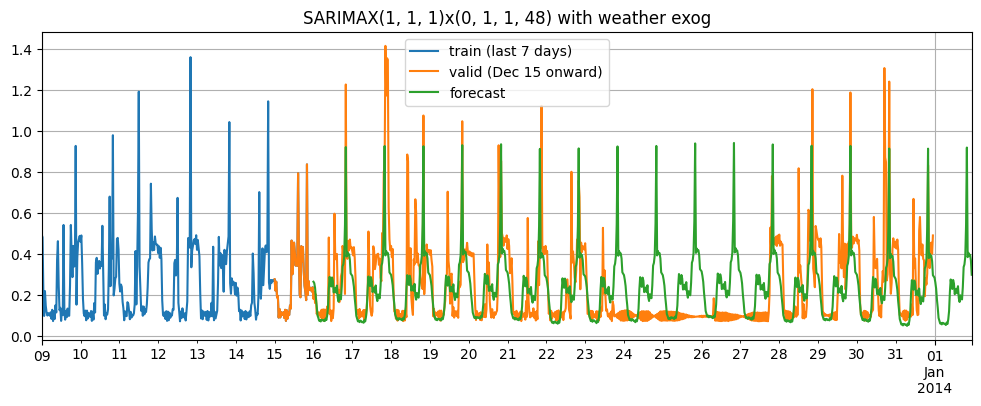

In [21]:
pred = results.get_forecast(steps=len(y_valid), exog=X_valid)
forecast = pred.predicted_mean

mae = mean_absolute_error(y_valid, forecast)
print(f'MAE (2013 holdout): {mae:.4f}')

fig, ax = plt.subplots(figsize=(12, 4))
y_train.tail(7 * 48).plot(ax=ax, label='train (last 7 days)')
y_valid.plot(ax=ax, label='valid (Dec 15 onward)')
forecast.plot(ax=ax, label='forecast')
ax.set_title(f'SARIMAX{order}x{seasonal_order} with weather exog')
ax.grid(True)
ax.legend()
plt.show()


## 11) Add weekday/weekend feature
We add a simple weekend indicator to capture systematic level shifts between
weekdays and weekends.


In [11]:
data['is_weekend'] = (data.index.dayofweek >= 5).astype(int)
data[['is_weekend']].value_counts()


is_weekend
0             12527
1              4992
Name: count, dtype: int64

## 12) SARIMAX with weather + weekend exogenous
This model extends the weather exogenous inputs with a weekend flag.


In [14]:
exog_cols_weekend = exog_cols + ['is_weekend']

train_w = data.loc[:split_date]
valid_w = data.loc[split_date:]

y_train_w = train_w['energy(kWh/hh)']
y_valid_w = valid_w['energy(kWh/hh)']
X_train_w = train_w[exog_cols_weekend]
X_valid_w = valid_w[exog_cols_weekend]


In [15]:

model_w = SARIMAX(
    y_train_w,
    exog=X_train_w,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results_w = model_w.fit(disp=False)
results_w.summary()


/Users/eugeneleach/.pyenv/versions/3.12.9/envs/forecast-and-flex/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyboardInterrupt: 

In [ ]:
pred_w = results_w.get_forecast(steps=len(y_valid_w), exog=X_valid_w)
forecast_w = pred_w.predicted_mean

mae_w = mean_absolute_error(y_valid_w, forecast_w)
print(f'MAE (2013 holdout, weekend exog): {mae_w:.4f}')

fig, ax = plt.subplots(figsize=(12, 4))
y_train_w.tail(7 * 48).plot(ax=ax, label='train (last 7 days)')
y_valid_w.plot(ax=ax, label='valid (Dec 15 onward)')
forecast_w.plot(ax=ax, label='forecast (weekend exog)')
ax.set_title(f'SARIMAX{order}x{seasonal_order} with weather + weekend')
ax.grid(True)
ax.legend()
plt.show()


## 13) Add meteorological seasons (UK/Northern Hemisphere)
We map months to seasons and one-hot encode them so the model can learn
different baselines across winter/spring/summer/autumn.


In [ ]:
def month_to_season(month):
    if month in (12, 1, 2):
        return 'winter'
    if month in (3, 4, 5):
        return 'spring'
    if month in (6, 7, 8):
        return 'summer'
    return 'autumn'

data['season'] = data.index.month.map(month_to_season)
season_dummies = pd.get_dummies(data['season'], prefix='season', drop_first=True)
data = pd.concat([data.drop(columns=['season']), season_dummies], axis=1)
season_dummies.head()


## 14) SARIMAX with weather + weekend + season exogenous
We extend the exogenous set with season dummies to capture longer-term
shifts in consumption across the year.


In [ ]:
season_cols = list(season_dummies.columns)
exog_cols_season = exog_cols_weekend + season_cols

train_s = data.loc[:split_date]
valid_s = data.loc[split_date:]

y_train_s = train_s['energy(kWh/hh)']
y_valid_s = valid_s['energy(kWh/hh)']
X_train_s = train_s[exog_cols_season]
X_valid_s = valid_s[exog_cols_season]

model_s = SARIMAX(
    y_train_s,
    exog=X_train_s,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results_s = model_s.fit(disp=False)
results_s.summary()


In [ ]:
pred_s = results_s.get_forecast(steps=len(y_valid_s), exog=X_valid_s)
forecast_s = pred_s.predicted_mean

mae_s = mean_absolute_error(y_valid_s, forecast_s)
print(f'MAE (2013 holdout, weekend + seasons): {mae_s:.4f}')

fig, ax = plt.subplots(figsize=(12, 4))
y_train_s.tail(7 * 48).plot(ax=ax, label='train (last 7 days)')
y_valid_s.plot(ax=ax, label='valid (Dec 15 onward)')
forecast_s.plot(ax=ax, label='forecast (weekend + seasons)')
ax.set_title(f'SARIMAX{order}x{seasonal_order} with weather + weekend + seasons')
ax.grid(True)
ax.legend()
plt.show()
